(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [16]:
# Import libraries for scientific computing
import numpy as np
import scipy as sp
import pandas as pd

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the context for the plots
sns.set_context("notebook")
# Set the style for the plots
sns.set_style("darkgrid")
# Set default color palette to colorblind
sns.set_palette("colorblind")

# Bayesian inference with Boolean data

In this notebook, we will explore a simple Bayesian model to describe real
boolean data. The data we will use comes to us from Caltech, courtesy of Justin
Bois. In an experiment performed for the introductory biology class at Caltech, a neural circuit in *C. elegans* was modified to respond to blue light.

There are six non-motor neurons involved in this circuit used by the worm to
respond to environmental cues and trigger a reversal&mdash;a movement in the
opposite direction. These six neurons include four sensory neurons (ALM, AVM,
ASH, and PLM), and two interneurons (AVA and AVD). The circuit is shown in the
figure below. Each of the sensory neurons is responsive to a different type of
stimulus. For the experiment, they focused on the ASH neuron that responds to
chemosensory stimuli such as toxins. The signal sent by the sensory neurons are
integrated by the two command interneurons. For the interneurons to activate the
motor neurons and trigger a reversal, the sum of the stimuli must be above
certain threshold. If this event occurs, the command neurons fire, passing the
signal to the motor neurons that modulate the worm's movement.

![](reversal_neural_network.png)

For the experiment we will analyze, the students used three strains of worms:
- the `ASH` strain that has a channelrhodopsin expressed only in the ASH neuron.
- the `AVA` strain that has a channelrhodopsin expressed only in the AVA neuron.
- the `WT` control strain that has no channelrhodopsin expressed.

When the blue light is shined on the worms, the channelrhodopsin in the ASH and
AVA neurons should be activated, allowing sodium and calcium ions to flow into
the neuron. This influx of ions should depolarize the neuron and trigger a
reversal.

The objective of the measurements is to quantify how robustly the blue light
triggers a reversal in the `ASH` and `AVA` strains compared to the `WT` strain.
The data we got is from several trials over different years that the students
performed. 

Let's begin by loading the data.

In [17]:
# Load data as a pandas dataframe
df = pd.read_csv('./data/boolean_data.csv')

df.head()

,Strain,Year,Trials,Reversals
0,WT,2017,55,7
1,ASH,2017,54,18
2,AVA,2017,52,28
3,WT,2016,36,6
4,ASH,2016,35,12


## Writing the model

The first step in any Bayesian analysis is always to write down Bayes' theorem.
As we saw before, we can write it as
$$
P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)},
\tag{1}
$$
where $\theta$ represents the parameters we want to infer, and $D$ is the data.

As we saw in theory, and we will show in practice here, the challenge of working
with Bayes' theorem is computing the numerator $P(D)$ that usually involves an
integral
$$
P(D) = \int P(D | \theta) P(\theta) d\theta,
$$
for continuous parameters, or a sum
$$
P(D) = \sum P(D | \theta) P(\theta),
$$
for discrete parameters.

For most cases, this integral or sum is intractable, and we need to resort to
numerical methods to approximate the posterior distribution. So, for now, let's
ignore this normalization constant and focus on the numerator of Bayes' theorem.

### Defining the likelihood function $P(D \mid \theta)$

Defining our likelihood function comes down to translating a "simple story" that
matches our data's generative process into a probability distribution. In our
particular case, where our data is binary, we can imagine that every time we
activate the light, each worm "flips a biased coin" that determines whether it
reverses or not. This simple story should remind us of the Bernoulli
distribution. 

The Bernoulli distribution is a discrete distribution with a single parameter,
call it $p$, that describes the probability of success. In our case, success
means that we observe a reversal. Let us then define the outcome of our i-th
experiment as $d_i$ where $d_i = 1$ if we observe a reversal and $d_i = 0$ if we
do not. The probability of observing a reversal given a parameter $p$ is then
given by
$$
P(d_i = 1 \mid p) = p,
\tag{2}
$$
and the probability of not observing a reversal is
$$
P(d_i = 0 \mid p) = 1 - p.
\tag{3}
$$

Moreover, given that we repeated the experiment multiple times, we will assume
that each trial is independent. This means that the probability of observing
$n$ out of $N$ reversals is given by the product of the probabilities of each
trial. Mathematically, independence is then expressed as
$$
P(D \mid p) = \prod_{i=1}^N P(d_i \mid p).
\tag{4}
$$

However, notice that our data is not reported on a worm-by-worm basis. Instead,
we have the total number of reversals $n$ and the total number of trials $N$.
Therefore, there is a degeneracy in the sense that if we observe, say three
reversals, in trials 1, 5, and 7, the likelihood of observing also three
reversals in trials 2, 3, and 4 is the same. This is because we are not keeping
track of the order of the reversals. So a better story to match of our data
structure is to imagine we flip a biased coin $N$ times and only keep track of
the total number of successes. This is the story of the binomial distribution,
whose probability mass function is given by
$$
P(n \mid N, p) = \binom{N}{n} p^n (1 - p)^{N - n},
\tag{5}
$$
where $\binom{N}{n}$ is the binomial coefficient, which is the number of ways of
observing $n$ successes in $N$ trials.

Moreover, notice that we have data over multiple years. If we again assume that
each year is independent, we can write the likelihood of observing all the data
as
$$
P(D \mid p) = \prod_{j=1}^J P(n_j \mid N_j, p),
\tag{6}
$$
where now the subindex $j$ denotes the year of the experiment.

Let's plot the binomial distribution for different values of $p$ to get a
feeling for how it looks.

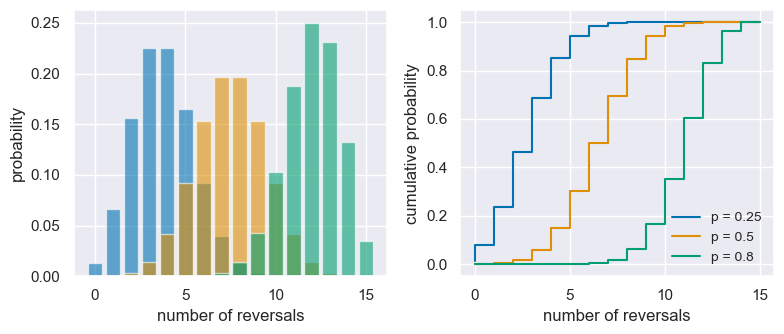

In [18]:
# Define the number of trials and the probability of success
N = 15
p_success = [0.25, 0.5, 0.8]

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# Loop over the different values of p
for (i, p) in enumerate(p_success):
    # Compute the binomial PMF using the scipy.stats.binom.pmf function
    prob = sp.stats.binom.pmf(np.arange(N+1), N, p)

    # Plot the binomial PMF
    ax[0].bar(np.arange(N+1), prob, label='p = {}'.format(p), alpha=0.6)

    # Plot the binomial CDF
    ax[1].step(np.arange(N+1), np.cumsum(prob), label='p = {}'.format(p))


# Label the axes
ax[0].set_xlabel('number of reversals')
ax[0].set_ylabel('probability')

ax[1].set_xlabel('number of reversals')
ax[1].set_ylabel('cumulative probability')

# Add legend on the second axis lower right corner
ax[1].legend(loc='lower right', frameon=False, fontsize=10)

fig.tight_layout()

### Defining the prior $P(\theta)$

One of the most controversial aspects&mdash;for the wrong reasons in my
opinion&mdash;of Bayesian inference is the selection of a prior probability
distribution. The arguments against the prior usualy revolve around the idea
that by selecting a prior, we are injecting our beliefs into the analysis, while
"science should be as objective as possible." However, this argument is
completely flawed. Yes, it is true that science should remain as objective as
possible, but the selection of a prior is not an arbitrary choice. Instead, it
is an opportunity to inject domain expertise into the analysis. This means that
we never perform science in a vacuum. We always have some prior knowledge about
the system we are studying. This knowledge can come from previous experiments,
knowledge of the literature, or even from the physical constraints of the
system. Furthermore, no analysis is free from assumptions. Even the most
"unbiased methods" have assumptions that are not always explicit. So, the
selection of a prior is not a choice between injecting or not injecting beliefs
into the analysis. Instead, it is a choice between injecting explicit and
transparent beliefs or implicit and opaque assumptions.

With that philosophical rant out of the way, let's define our prior. In our
case, our parameter $p$ has the strong constraint that it must be between 0 and
and 1 as it represents a probability. A common choice for this type of prior is
the so-called Beta distribution. The Beta distribution is a continuous
distribution with two parameters, $\alpha$ and $\beta$, that is defined in the
interval $[0, 1]$. The probability density function of the Beta distribution is
$$
P(p \mid \alpha, \beta) = \frac{p^{\alpha - 1} (1 - p)^{\beta - 1}}{B(\alpha, \beta)},
\tag{7}
$$
where $B(\alpha, \beta)$ is the Beta function, which is a normalization
constant. Although, the equation doesn't seem completely intuitive, if we plot a
few examples of the Beta distribution, we can see that it is a flexible
distribution that can take many shapes.

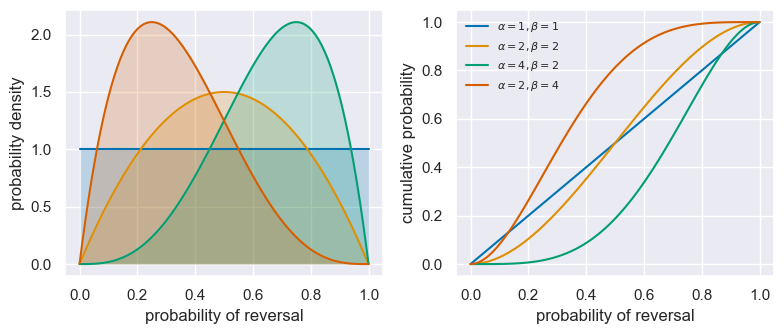

In [19]:
# Define list of alpha and beta values to plot
alpha_beta = [(1, 1), (2, 2), (4, 2), (2, 4)]

# Define range of x values
p = np.linspace(0, 1, 100)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# Loop over the different values of alpha and beta
for (i, (alpha, beta)) in enumerate(alpha_beta):
    # Compute the beta PDF using the scipy.stats.beta.pdf function
    prob = sp.stats.beta.pdf(p, alpha, beta)

    # Plot the beta PDF
    ax[0].plot(p, prob, label=r'$\alpha = {}, \beta = {}$'.format(alpha, beta))
    # Filled area under the curve
    ax[0].fill_between(p, prob, alpha=0.2)

    # Plot the beta CDF
    ax[1].plot(
        p,
        sp.stats.beta.cdf(p, alpha, beta),
        label=r'$\alpha = {}, \beta = {}$'.format(alpha, beta)
    )

# Add legend on the second axis uper left corner
ax[1].legend(loc='upper left', frameon=False, fontsize=8)

# Label the axes
ax[0].set_xlabel('probability of reversal')
ax[0].set_ylabel('probability density')

ax[1].set_xlabel('probability of reversal')
ax[1].set_ylabel('cumulative probability')

fig.tight_layout()

### Putting everything together

Having defined our prior and likelihood function, we have everything we need to
compute the posterior distribution. We can then write the posterior as
$$
P(p \mid D) \propto P(D \mid p) P(p) = \prod_{j=1}^J P(n_j \mid N_j, p) P(p),
\tag{8}
$$
where we are explicitly ignoring the normalization constant.

This is a quantity that we can compute for any value of $p$. Let's go ahead and
define a function to compute the posterior distribution for a given set of data.

In [20]:
def log_posterior(p, data, alpha, beta):
    """
    Compute the log posterior of the beta-binomial model.

    Arguments:
    p : float in [0, 1], probability of reversal.
    data : 2D array, first column is the number of trials, second column is the
    number of reversals.
    alpha : float, shape parameter of the prior beta distribution.
    beta : float, shape parameter of the prior beta distribution.

    Returns:
    log_post : float, unnormalized log posterior of the beta-binomial model
    """
    # Extract the number of trials and the number of reversals
    trials = data[:, 0]
    reversals = data[:, 1]

    # Compute the log likelihood
    log_like = sum([
        sp.stats.binom.logpmf(r, n, p) for r, n in zip(reversals, trials)
    ])

    # Compute the log prior
    log_prior = sp.stats.beta.logpdf(p, a=alpha, b=beta)

    # Compute the log posterior
    log_post = log_like + log_prior

    return log_post

Notice that we defined a function to compute the log of the posterior rather
than the posterior itself. This is because the posterior is a product of many
small numbers, which can lead to numerical underflow. By working with the log of
the posterior, we avoid this issue.

With this function, we can now compute the unnormalized posterior distribution.

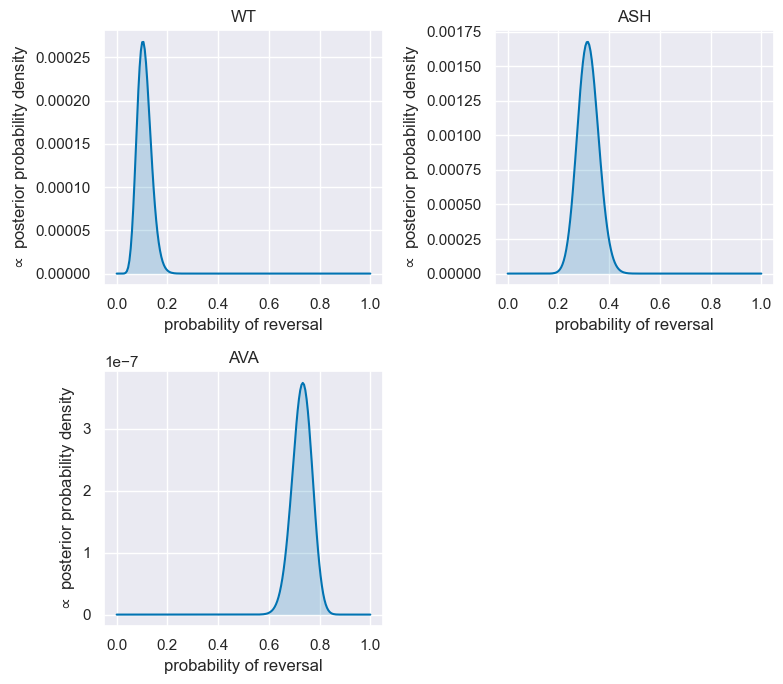

In [21]:
# Define the data
data_wt = df[(df.Strain == 'WT')][['Trials', 'Reversals']].values
data_ash = df[(df.Strain == 'ASH')][['Trials', 'Reversals']].values
data_ava = df[(df.Strain == 'AVA')][['Trials', 'Reversals']].values

# Define dictionary with the data
data_dict = {
    'WT': data_wt,
    'ASH': data_ash,
    'AVA': data_ava
}

# Define values of alpha and beta
alpha = 1
beta = 1

# Define range of x values
p = np.linspace(0, 1, 200)

# Initialize figure
fig, ax = plt.subplots(2, 2, figsize=(8, 7))

# Flatten the axis array
ax = ax.flatten()

# Loop over the different datasets
for (i, (strain, data)) in enumerate(data_dict.items()):
    # Compute the log posterior
    log_post = [log_posterior(p_i, data, alpha, beta) for p_i in p]

    # Plot the posterior
    ax[i].plot(p, np.exp(log_post))
    # Fill the area under the curve
    ax[i].fill_between(p, np.exp(log_post), alpha=0.2)

    # Add subplot title
    ax[i].set_title(strain)

    # Label the axes
    ax[i].set_xlabel('probability of reversal')
    ax[i].set_ylabel(r'$\propto$ posterior probability density')

# Turn off the axis for the last subplot
ax[-1].axis('off')

fig.tight_layout()

We cannot plot the posterior distributions on the same axis because they are not
on the same scale since they are not normalized. Next, we will normalize the
posterior distributions and plot them on the same axis.

### Numerical computation of the evidence $P(D)$

To remove that proportionality sign, all we have left to do is to compute the
evidence $P(D)$. As we saw before, this is given by the integral
(marginalization) over the parameter space. In our case, this parameter space is
extremely easy to compute as it is only one-dimensional, constrained between 0
and 1. We can then compute the evidence by a simple numerical quadrature.

In [22]:
def log_posterior_norm(p, data, alpha, beta):
    """
    Compute the normalized log posterior of the beta-binomial model.

    Arguments:
    p : array of float in [0, 1], probability of reversal.
    data : 2D array, first column is the number of trials, second column is the
    number of reversals.
    alpha : float, shape parameter of the prior beta distribution.
    beta : float, shape parameter of the prior beta distribution.

    Returns:
    log_post : float, normalized log posterior of the beta-binomial model
    """
    # Extract the number of trials and the number of reversals
    trials = data[:, 0]
    reversals = data[:, 1]

    # Compute the log likelihood
    log_like = [
        sum([
            sp.stats.binom.logpmf(r, n, p_i) for r, n in zip(reversals, trials)
        ]) for p_i in p
    ]

    # Compute the log prior
    log_prior = sp.stats.beta.logpdf(p, a=alpha, b=beta)

    # Compute the log posterior
    log_post = log_like + log_prior

    # Compute the log marginal likelihood
    log_marg_like = np.log(np.trapz(np.exp(log_post), p))

    # Compute the normalized log posterior
    log_post_norm = log_post - log_marg_like

    return log_post_norm

Let's now plot all the normalized posterior distributions on the same axis to better compare them.

Text(0, 0.5, 'posterior probability density')

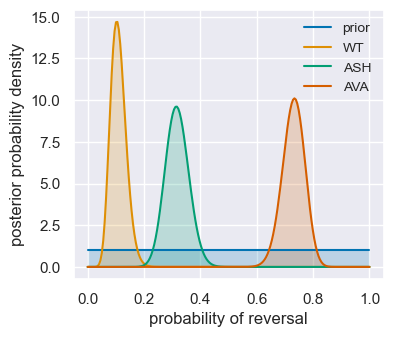

In [23]:
# Define the data
data_wt = df[(df.Strain == 'WT')][['Trials', 'Reversals']].values
data_ash = df[(df.Strain == 'ASH')][['Trials', 'Reversals']].values
data_ava = df[(df.Strain == 'AVA')][['Trials', 'Reversals']].values

# Define dictionary with the data
data_dict = {
    'WT': data_wt,
    'ASH': data_ash,
    'AVA': data_ava
}

# Define values of alpha and beta
alpha = 1
beta = 1

# Define range of x values
p = np.linspace(0, 1, 200)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

# Plot prior
ax.plot(p, sp.stats.beta.pdf(p, alpha, beta), label='prior')
# Fill the area under the curve
ax.fill_between(p, sp.stats.beta.pdf(p, alpha, beta), alpha=0.2)

# Loop over the different datasets
for (i, (strain, data)) in enumerate(data_dict.items()):
    # Compute the log posterior
    log_post = log_posterior_norm(p, data, alpha, beta)

    # Plot the posterior
    ax.plot(p, np.exp(log_post), label=strain)
    # Fill the area under the curve
    ax.fill_between(p, np.exp(log_post), alpha=0.2, label=None)

# Add legend with merged labels
ax.legend(loc='upper right', frameon=False, fontsize=10)

# Label the axes
ax.set_xlabel('probability of reversal')
ax.set_ylabel('posterior probability density')

# Conclusion

In this simple exercise, we went through the entire process of Bayesian
inference. We defined a simple model that describes the generative process of
our data, defined a prior distribution that encodes our prior knowledge, and
computed the posterior distribution.

Obviously, this is a very simple example. However, the same principles apply to
any Bayesian analysis. The only difference is that the computations become more
challenging as models can be complex and multi-dimensional. For those cases,
naive numerical quadrature as we just did is not feasible. Instead, we need to
resort to more sophisticated methods like Markov Chain Monte Carlo (MCMC) or
Variational Inference.

In [24]:
%load_ext watermark
%watermark -v -p numpy,scipy,pandas,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.22.2

numpy     : 1.26.4
scipy     : 1.12.0
pandas    : 2.2.1
matplotlib: 3.8.3
seaborn   : 0.13.2

